In [54]:
!pip install matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Base directory for parquet files
DATA_DIR = Path("..") / "data" / "Statsbomb"
DATA_DIR

PosixPath('../data/Statsbomb')

In [ ]:
# Matches: one row per match
matches = pd.read_parquet(DATA_DIR / "matches.parquet")
matches.head()

,match_id,match_date,match_week,match_status,match_status_360,kickoff,home_score,away_score,competition_id,competition,competition_stage,season_id,season,home_team_id,home_team,home_managers,away_team_id,away_team,away_managers,stadium_id,stadium,referee_id,referee,last_updated,last_updated_360,data_version,shot_fidelity_version,xy_fidelity_version,competition_name,gender,is_youth,is_international,country_name,season_name,match_updated,match_available_360
0,9880,2018-04-14,32,available,scheduled,16:15:00,2,1,11,La Liga,Regular Season,1,2017/2018,217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""...",207,Valencia,"[{""id"":211,""name"":""Marcelino García Toral"",""ni...",342.0,Spotify Camp Nou,2728.0,Carlos del Cerro Grande,2023-02-08T17:23:53.901920,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,NaN
1,9912,2018-04-29,35,available,scheduled,20:45:00,2,4,11,La Liga,Regular Season,1,2017/2018,219,RC Deportivo La Coruña,"[{""id"":371,""name"":""Clarence Seedorf"",""nickname...",217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""...",4658.0,Estadio Abanca-Riazor,2602.0,Ricardo De Burgos Bengoetxea,2022-12-05T14:42:44.641092,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,NaN
2,9924,2018-05-06,36,available,scheduled,20:45:00,2,2,11,La Liga,Regular Season,1,2017/2018,217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""...",220,Real Madrid,"[{""id"":56,""name"":""Zinédine Zidane"",""nickname"":...",342.0,Spotify Camp Nou,2608.0,Alejandro José Hernández Hernández,2022-12-01T03:25:12.063586,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,NaN
3,9855,2018-03-18,29,available,scheduled,16:15:00,2,0,11,La Liga,Regular Season,1,2017/2018,217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""...",215,Athletic Club,"[{""id"":210,""name"":""José Ángel Ziganda Lacunza""...",342.0,Spotify Camp Nou,2575.0,Santiago Jaime Latre,2022-12-01T02:33:31.178193,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,NaN
4,9827,2018-03-01,26,available,scheduled,21:00:00,1,1,11,La Liga,Regular Season,1,2017/2018,208,Las Palmas,"[{""id"":220,""name"":""Francisco Jémez Martín"",""ni...",217,Barcelona,"[{""id"":227,""name"":""Ernesto Valverde Tejedor"",""...",357.0,Estadio de Gran Canaria,180.0,Antonio Miguel Mateu Lahoz,2022-08-04T17:18:06.540844,2021-06-13T16:17:31.694,1.1.0,2,2,La Liga,male,False,False,Spain,2017/2018,2025-07-14T10:01:16.674864,NaN


In [23]:
# Events: one row per on-ball action (passes, shots, etc.)
events = pd.read_parquet(DATA_DIR / "events.parquet")
events.head()

,id,index_num,period,minute,second,timestamp,duration,location_x,location_y,possession,possession_team_id,possession_team,out,off_camera,counterpress,under_pressure,type_id,type,match_id,team_id,team,player_id,player,position_id,position,play_pattern_id,play_pattern,shot_end_location_x,shot_end_location_y,shot_end_location_z,shot_statsbomb_xg,shot_outcome,shot_technique,shot_body_part,shot_type,shot_key_pass_id,shot_freeze_frame,shot_first_time,shot_deflected,shot_aerial_won,shot_follows_dribble,shot_one_on_one,shot_open_goal,shot_redirect,shot_saved_off_target,shot_saved_to_post,pass_end_location_x,pass_end_location_y,pass_recipient_id,pass_recipient,pass_length,pass_angle,pass_height,pass_body_part,pass_type,pass_outcome,pass_technique,pass_assisted_shot_id,pass_goal_assist,pass_shot_assist,pass_cross,pass_switch,pass_through_ball,pass_aerial_won,pass_deflected,pass_inswinging,pass_outswinging,pass_no_touch,pass_cut_back,pass_straight,pass_miscommunication,carry_end_location_x,carry_end_location_y,dribble_outcome,dribble_nutmeg,dribble_overrun,dribble_no_touch,duel_type,duel_outcome,foul_committed_card,foul_committed_type,foul_committed_offensive,foul_committed_advantage,foul_committed_penalty,foul_won_defensive,foul_won_advantage,foul_won_penalty,goalkeeper_type,goalkeeper_outcome,goalkeeper_technique,goalkeeper_position,goalkeeper_body_part,goalkeeper_end_location_x,goalkeeper_end_location_y,clearance_body_part,clearance_aerial_won,clearance_head,clearance_left_foot,clearance_right_foot,interception_outcome,block_deflection,block_offensive,block_save_block,ball_recovery_offensive,ball_recovery_failure,miscontrol_aerial_won,substitution_replacement_id,substitution_replacement_name,substitution_outcome,fifty_fifty_outcome,bad_behaviour_card,injury_stoppage_in_chain
0,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,1,1,0,0,00:00:00,0.000000,NaN,NaN,1,217,Barcelona,False,False,False,False,35,Starting XI,15946,217,Barcelona,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False
1,0300039d-150d-41e4-b29a-76602ef002e6,2,1,0,0,00:00:00,0.000000,NaN,NaN,1,217,Barcelona,False,False,False,False,35,Starting XI,15946,206,Deportivo Alavés,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False
2,491e8901-7630-4cc8-b57b-937dddff2eaa,3,1,0,0,00:00:00,0.000000,NaN,NaN,1,217,Barcelona,False,False,False,False,18,Half Start,15946,217,Barcelona,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False
3,757b85ad-ddfe-44d5-b893-c23a9fb709d8,4,1,0,0,00:00:00,0.000000,NaN,NaN,1,217,Barcelona,False,False,False,False,18,Half Start,15946,206,Deportivo Alavés,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,

In [8]:
# Lineups: player participation, positions, and cards
lineups = pd.read_parquet(DATA_DIR / "lineups.parquet")
lineups.head(10)


,match_id,team_id,player_id,player_name,player_nickname,jersey_number,country_id,country_name,team_name,position_name,from_time,to_time,from_period,to_period,card_time,card_type,card_reason
0,15946,206,6839,Daniel Alejandro Torres Rojas,Dani Torres,16,49.0,Colombia,Deportivo Alavés,Center Defensive Midfield,00:00,67:48,1.0,2.0,09:15,Yellow Card,Foul Committed
1,15946,206,6855,Guillermo Alfonso Maripán Loaysa,Guillermo Maripán,6,45.0,Chile,Deportivo Alavés,Left Center Back,00:00,NaN,1.0,NaN,40:46,Yellow Card,Bad Behaviour
2,15956,217,5213,Gerard Piqué Bernabéu,Gerard Piqué,3,214.0,Spain,Barcelona,Right Center Back,00:00,NaN,1.0,NaN,59:01,Yellow Card,Foul Committed
3,15956,901,6760,Enes Ünal,NaN,9,233.0,Turkey,Real Valladolid,Right Center Forward,00:00,69:51,1.0,2.0,48:43,Yellow Card,Foul Committed
4,15973,217,8206,Arturo Erasmo Vidal Pardo,Arturo Vidal,22,45.0,Chile,Barcelona,Right Center Midfield,70:46,70:49,2.0,2.0,87:18,Yellow Card,Foul Committed
5,15973,217,8206,Arturo Erasmo Vidal Pardo,Arturo Vidal,22,45.0,Chile,Barcelona,Right Defensive Midfield,70:49,NaN,2.0,NaN,87:18,Yellow Card,Foul Committed
6,15973,902,6734,Luis Carlos Correia Pinto,Luisinho,16,183.0,Portugal,Huesca,Left Back,00:00,NaN,1.0,NaN,25:38,Yellow Card,Foul Committed
7,15973,902,11674,Damián Marcelo Musto,Damián Musto,23,11.0,Argentina,Huesca,Right Defensive Midfield,00:00,NaN,1.0,NaN,86:08,Yellow Card,Foul Committed
8,15978,210,6671,Asier Illarramendi Andonegi,Asier Illarramendi,4,214.0,Spain,Real Sociedad,Left Defensive Midfield,00:00,81:36,1.0,2.0,42:57,Yellow Card,Foul Committed
9,15978,217,5492,Samuel Yves Umtiti,Samuel Umtiti,23,78.0,France,Barcelona,Left Center Back,00:00,NaN,1.0,NaN,86:32,Yellow Card,Bad Behaviour


In [ ]:
# Three-sixty: player locations at the moment of an event
three_sixty = pd.read_parquet(DATA_DIR / "three_sixty.parquet")
three_sixty.head(20)

,match_id,id,event_uuid,teammate,actor,keeper,location_x,location_y,visible_area
0,3788742,174148,403db150-7e25-4850-aca5-aa7c54d0bbc3,False,False,False,86.038681,34.486008,"[85.9122658313659,78.7684484599881,54.39686712..."
1,3788742,174149,403db150-7e25-4850-aca5-aa7c54d0bbc3,True,False,False,89.149490,25.236403,"[85.9122658313659,78.7684484599881,54.39686712..."
2,3788742,174150,403db150-7e25-4850-aca5-aa7c54d0bbc3,False,False,False,89.975533,66.690712,"[85.9122658313659,78.7684484599881,54.39686712..."
3,3788742,174151,403db150-7e25-4850-aca5-aa7c54d0bbc3,True,False,False,91.753372,31.549557,"[85.9122658313659,78.7684484599881,54.39686712..."
4,3788742,174152,403db150-7e25-4850-aca5-aa7c54d0bbc3,False,False,False,92.088539,48.391106,"[85.9122658313659,78.7684484599881,54.39686712..."
5,3788742,174153,403db150-7e25-4850-aca5-aa7c54d0bbc3,False,False,False,92.666740,30.899391,"[85.9122658313659,78.7684484599881,54.39686712..."
6,3788742,174154,403db150-7e25-4850-aca5-aa7c54d0bbc3,True,False,False,93.159355,11.337386,"[85.9122658313659,78.7684484599881,54.39686712..."
7,3788742,174155,403db150-7e25-4850-aca5-aa7c54d0bbc3,False,False,False,94.005508,18.978586,"[85.9122658313659,78.7684484599881,54.39686712..."
8,3788742,174156,403db150-7e25-4850-aca5-aa7c54d0bbc3,False,False,False,94.195999,36.537113,"[85.9122658313659,78.7684484599881,54.39686712..."
9,3788742,174157,403db150-7e25-4850-aca5-aa7c54d0bbc3,True,False,False,97.775566,33.741833,"[85.9122658313659,78.7684484599881,54.39686712..."


In [ ]:
# Reference: lookup table for teams, players, positions, etc.
reference = pd.read_parquet(DATA_DIR / "reference.parquet")
reference.head()

,table_name,id,name,extra_info
0,team,2021,Jamshedpur,male
1,team,7285,NorthEast United,male
2,team,865,England Women's,female
3,team,852,Norway Women's,female
4,team,1209,Chile Women's,female


In [56]:
# Pick one match to explore deeply
match_id = matches.iloc[10]["match_id"]
match_id

np.int32(9736)

In [57]:
m_events = events[events["match_id"] == match_id].copy()
# Sort events in actual match order
m_events = m_events.sort_values(["period", "minute", "second"])
m_events.head(15)

,id,index_num,period,minute,second,timestamp,duration,location_x,location_y,possession,possession_team_id,possession_team,out,off_camera,counterpress,under_pressure,type_id,type,match_id,team_id,team,player_id,player,position_id,position,play_pattern_id,play_pattern,shot_end_location_x,shot_end_location_y,shot_end_location_z,shot_statsbomb_xg,shot_outcome,shot_technique,shot_body_part,shot_type,shot_key_pass_id,shot_freeze_frame,shot_first_time,shot_deflected,shot_aerial_won,shot_follows_dribble,shot_one_on_one,shot_open_goal,shot_redirect,shot_saved_off_target,shot_saved_to_post,pass_end_location_x,pass_end_location_y,pass_recipient_id,pass_recipient,pass_length,pass_angle,pass_height,pass_body_part,pass_type,pass_outcome,pass_technique,pass_assisted_shot_id,pass_goal_assist,pass_shot_assist,pass_cross,pass_switch,pass_through_ball,pass_aerial_won,pass_deflected,pass_inswinging,pass_outswinging,pass_no_touch,pass_cut_back,pass_straight,pass_miscommunication,carry_end_location_x,carry_end_location_y,dribble_outcome,dribble_nutmeg,dribble_overrun,dribble_no_touch,duel_type,duel_outcome,foul_committed_card,foul_committed_type,foul_committed_offensive,foul_committed_advantage,foul_committed_penalty,foul_won_defensive,foul_won_advantage,foul_won_penalty,goalkeeper_type,goalkeeper_outcome,goalkeeper_technique,goalkeeper_position,goalkeeper_body_part,goalkeeper_end_location_x,goalkeeper_end_location_y,clearance_body_part,clearance_aerial_won,clearance_head,clearance_left_foot,clearance_right_foot,interception_outcome,block_deflection,block_offensive,block_save_block,ball_recovery_offensive,ball_recovery_failure,miscontrol_aerial_won,substitution_replacement_id,substitution_replacement_name,substitution_outcome,fifty_fifty_outcome,bad_behaviour_card,injury_stoppage_in_chain
12114121,23080412-cdc5-49b3-9274-6655bb0519ab,1,1,0,0,00:00:00,0.000,NaN,NaN,1,220,Real Madrid,False,False,False,False,35,Starting XI,9736,220,Real Madrid,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False
12114122,e4ae4d73-a3df-4497-b08f-68a472f37eb7,2,1,0,0,00:00:00,5.694,NaN,NaN,1,220,Real Madrid,False,False,False,False,35,Starting XI,9736,217,Barcelona,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False
12114123,a35dd285-e477-435b-b1d2-16755678d069,3,1,0,0,00:00:00,0.000,NaN,NaN,1,220,Real Madrid,False,False,False,False,18,Half Start,9736,220,Real Madrid,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False
12114124,7ae2eb53-425a-4213-a744-208556248111,4,1,0,0,00:00:00,0.000,NaN,NaN,1,220,Real Madrid,False,False,False,False,18,Half Start,9736,217,Barcelona,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,Fa

In [58]:
m_events["type"].value_counts().head(15)

type
Pass              1092
Ball Receipt*     1063
Carry              952
Pressure           519
Ball Recovery       69
Duel                40
Dribble             40
Block               35
Goal Keeper         32
Shot                31
Dribbled Past       29
Foul Committed      28
Foul Won            27
Interception        26
Clearance           24
Name: count, dtype: int64

In [59]:
shots = m_events[m_events["type"] == "Shot"]

shots[[
    "id",
    "minute",
    "second",
    "player",
    "team",
    "shot_statsbomb_xg"
]].head(10)

,id,minute,second,player,team,shot_statsbomb_xg
12114191,d92a3d4d-6a25-4d03-95d4-b24ad253cf97,1,48,Raphaël Varane,Real Madrid,0.134821
12114312,b10ec3b9-d60b-473a-b4b2-b82bd0264f8d,4,5,Daniel Carvajal Ramos,Real Madrid,0.012174
12115081,57991d47-51a7-458a-9a46-12e2143651b3,20,30,Cristiano Ronaldo dos Santos Aveiro,Real Madrid,0.037867
12115491,ff00265c-80a5-4a47-92bd-e67bd8fa002d,29,29,José Paulo Bezzera Maciel Júnior,Barcelona,0.131708
12115495,03780475-01ed-4755-b72f-a1a19da2030d,30,3,Gerard Piqué Bernabéu,Barcelona,0.072771
12115559,d838f77c-10dd-4c2d-83d6-4ddef0b6d372,30,55,Cristiano Ronaldo dos Santos Aveiro,Real Madrid,0.016621
12115564,7324c971-1469-4aac-95c4-c07ad9e26d7c,31,27,Cristiano Ronaldo dos Santos Aveiro,Real Madrid,0.059315
12115681,09dde05d-b364-440c-910e-dffa8f29952e,33,54,Karim Benzema,Real Madrid,0.066838
12115894,955344c7-2336-4080-b76f-826b18a999c2,38,49,José Paulo Bezzera Maciel Júnior,Barcelona,0.121541
12115968,17979a45-6d11-4b9f-bec5-0d6f86f12397,40,25,Luka Modrić,Real Madrid,0.022428


In [75]:
events[events["id"] == "bc666f81-ab94-4411-ac68-0d7542b6758d"]


,id,index_num,period,minute,second,timestamp,duration,location_x,location_y,possession,possession_team_id,possession_team,out,off_camera,counterpress,under_pressure,type_id,type,match_id,team_id,team,player_id,player,position_id,position,play_pattern_id,play_pattern,shot_end_location_x,shot_end_location_y,shot_end_location_z,shot_statsbomb_xg,shot_outcome,shot_technique,shot_body_part,shot_type,shot_key_pass_id,shot_freeze_frame,shot_first_time,shot_deflected,shot_aerial_won,shot_follows_dribble,shot_one_on_one,shot_open_goal,shot_redirect,shot_saved_off_target,shot_saved_to_post,pass_end_location_x,pass_end_location_y,pass_recipient_id,pass_recipient,pass_length,pass_angle,pass_height,pass_body_part,pass_type,pass_outcome,pass_technique,pass_assisted_shot_id,pass_goal_assist,pass_shot_assist,pass_cross,pass_switch,pass_through_ball,pass_aerial_won,pass_deflected,pass_inswinging,pass_outswinging,pass_no_touch,pass_cut_back,pass_straight,pass_miscommunication,carry_end_location_x,carry_end_location_y,dribble_outcome,dribble_nutmeg,dribble_overrun,dribble_no_touch,duel_type,duel_outcome,foul_committed_card,foul_committed_type,foul_committed_offensive,foul_committed_advantage,foul_committed_penalty,foul_won_defensive,foul_won_advantage,foul_won_penalty,goalkeeper_type,goalkeeper_outcome,goalkeeper_technique,goalkeeper_position,goalkeeper_body_part,goalkeeper_end_location_x,goalkeeper_end_location_y,clearance_body_part,clearance_aerial_won,clearance_head,clearance_left_foot,clearance_right_foot,interception_outcome,block_deflection,block_offensive,block_save_block,ball_recovery_offensive,ball_recovery_failure,miscontrol_aerial_won,substitution_replacement_id,substitution_replacement_name,substitution_outcome,fifty_fifty_outcome,bad_behaviour_card,injury_stoppage_in_chain
3591176,bc666f81-ab94-4411-ac68-0d7542b6758d,1096,1,31,54,00:31:54.583,0.0,64.0,58.099998,56,776,Denmark,False,False,False,False,38,Miscontrol,3788742,776,Denmark,5534.0,Simon Thorup Kjær,3.0,Right Center Back,1,Regular Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False


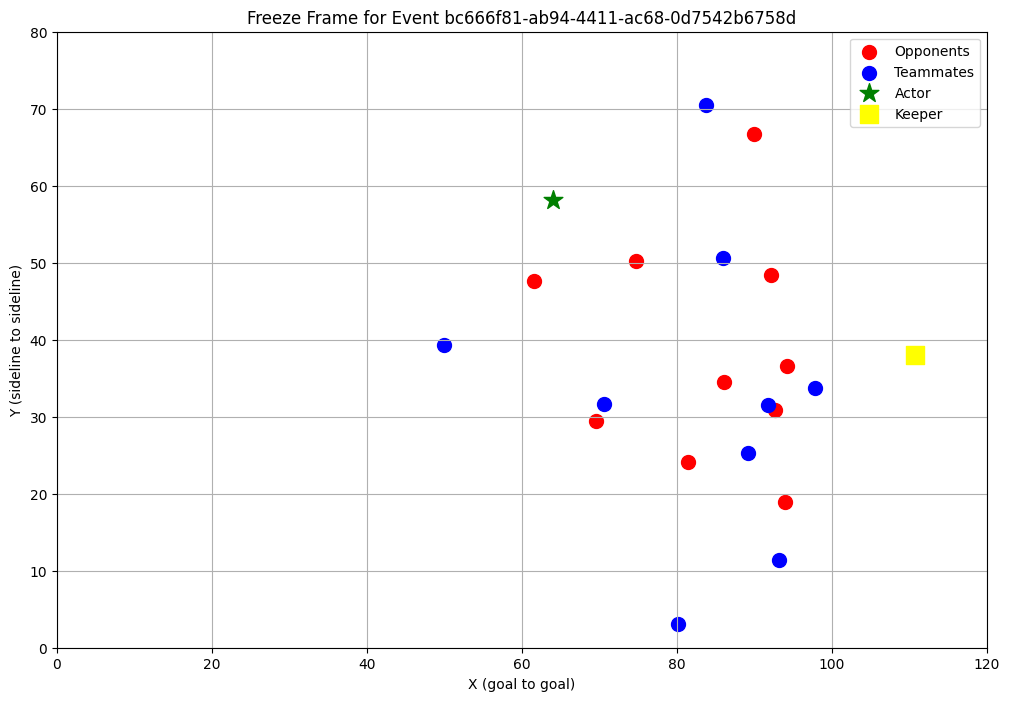

In [55]:
# Pick one event UUID (actor event)
event_uuid = "bc666f81-ab94-4411-ac68-0d7542b6758d"

# Filter frame
frame = three_sixty[three_sixty["event_uuid"] == event_uuid]

# Separate roles
actor = frame[frame["actor"] == True]
teammates = frame[frame["teammate"] & ~frame["actor"]]
opponents = frame[~frame["teammate"] & ~frame["actor"]]
keepers = frame[frame["keeper"]]

# Draw pitch
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 120)
ax.set_ylim(0, 80)
ax.set_xlabel("X (goal to goal)")
ax.set_ylabel("Y (sideline to sideline)")
ax.set_title(f"Freeze Frame for Event {event_uuid}")

# Plot players
ax.scatter(opponents["location_x"], opponents["location_y"], color="red", label="Opponents", s=100)
ax.scatter(teammates["location_x"], teammates["location_y"], color="blue", label="Teammates", s=100)
ax.scatter(actor["location_x"], actor["location_y"], color="green", label="Actor", s=200, marker="*")
ax.scatter(keepers["location_x"], keepers["location_y"], color="yellow", label="Keeper", s=150, marker="s")

# Add legend
ax.legend(loc="upper right")
ax.grid(True)
plt.show()